# DB Connections

In [37]:
import pandas as pd 
import pyodbc
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import math

# Use PIP INSTALL "scikit-learn" to install the library
from sklearn.cluster import KMeans

conn = sqlite3.connect('../data/processed/United_Outdoors.sqlite3')

# Custer Model Creation

In [38]:
product = pd.read_sql_query('SELECT * FROM Product', conn)
product_inventory = pd.read_sql_query('SELECT * FROM ProductInventory', conn)
merged = pd.merge(product, product_inventory, on='ProductID')

df = merged.loc[:, ['ProductID', 'Name_x', 'Quantity']]
df

,ProductID,Name_x,Quantity
0,771.0,"Mountain-100 Silver, 38",49
1,771.0,"Mountain-100 Silver, 38",100
2,772.0,"Mountain-100 Silver, 42",88
3,772.0,"Mountain-100 Silver, 42",65
4,773.0,"Mountain-100 Silver, 44",83
...,...,...,...
1076,3.0,Aniseed Syrup,443
1077,3.0,Aniseed Syrup,324
1078,4.0,Chef Anton's Cajun Seasoning,512
1079,4.0,Chef Anton's Cajun Seasoning,422


# One-Hot Encoding

In [39]:
dummies = pd.get_dummies(df.loc[:,'Name_x'])
dummies.head()

,AWC Logo Cap,Adjustable Race,All-Purpose Bike Stand,Aniseed Syrup,BB Ball Bearing,Bearing Ball,Bike Wash - Dissolver,Blade,Cable Lock,Chai,...,"Touring-3000 Yellow, 58","Touring-3000 Yellow, 62","Touring-Panniers, Large",Water Bottle - 30 oz.,"Women's Mountain Shorts, L","Women's Mountain Shorts, M","Women's Mountain Shorts, S","Women's Tights, L","Women's Tights, M","Women's Tights, S"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Combine & Remove

In [40]:
df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=['Name_x'])
df.head()

,ProductID,Quantity,AWC Logo Cap,Adjustable Race,All-Purpose Bike Stand,Aniseed Syrup,BB Ball Bearing,Bearing Ball,Bike Wash - Dissolver,Blade,...,"Touring-3000 Yellow, 58","Touring-3000 Yellow, 62","Touring-Panniers, Large",Water Bottle - 30 oz.,"Women's Mountain Shorts, L","Women's Mountain Shorts, M","Women's Mountain Shorts, S","Women's Tights, L","Women's Tights, M","Women's Tights, S"
0,771.0,49,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,771.0,100,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,772.0,88,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,772.0,65,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,773.0,83,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Building Clustering Model 2 Dimensions

In [42]:
df_2d = df[['ProductID', 'Quantity']]
df_2d.head()

,ProductID,Quantity
0,771.0,49
1,771.0,100
2,772.0,88
3,772.0,65
4,773.0,83


In [44]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit_predict(df_2d)

array([2, 2, 2, ..., 1, 1, 1])

In [47]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)

for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df_2d.columns[i]}'})
    
kmeans_centra

,ProductID,Quantity
0,874.223602,301.906832
1,405.700499,435.871880
2,845.272727,94.909091


In [48]:
for src_index, _ in df_2d.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df_2d.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df_2d.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df_2d.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df_2d

Afstand van bronindex 0 tot...
	Centrumindex 0:
		771.0 - 874.2236024844716 = -103.2236024844716
		49 - 301.90683229813664 = -252.90683229813664
	Totale euclidische som: 74616.97793295002
	Euclidische afstand: 273.1610842212888
------------------------------------------------
	Centrumindex 1:
		771.0 - 405.70049916805345 = 365.29950083194655
		49 - 435.87188019966703 = -386.87188019966703
	Totale euclidische som: 283113.57699729485
	Euclidische afstand: 532.084182246846
------------------------------------------------
	Centrumindex 2:
		771.0 - 845.2727272727273 = -74.27272727272725
		49 - 94.90909090909062 = -45.90909090909062
	Totale euclidische som: 7624.08264462807
	Euclidische afstand: 87.3159930632875
------------------------------------------------
{0: 273.1610842212888, 1: 532.084182246846, 2: 87.3159930632875}
2
Afstand van bronindex 1 tot...
	Centrumindex 0:
		771.0 - 874.2236024844716 = -103.2236024844716
		100 - 301.90683229813664 = -201.90683229813664
	Totale euclidische s

C:\Users\Noah\AppData\Local\Temp\ipykernel_191956\3398783965.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2d.at[src_index, 'Centrum'] = centrum_number


,ProductID,Quantity,Centrum
0,771.0,49,2.0
1,771.0,100,2.0
2,772.0,88,2.0
3,772.0,65,2.0
4,773.0,83,2.0
...,...,...,...
1076,3.0,443,1.0
1077,3.0,324,1.0
1078,4.0,512,1.0
1079,4.0,422,1.0



For k=2:
Inter-cluster distance between cluster 0 and cluster 1: 524.9618668701456
Average intra-cluster distance for cluster 0: 139.1165655711031
Average intra-cluster distance for cluster 1: 156.8326996718238


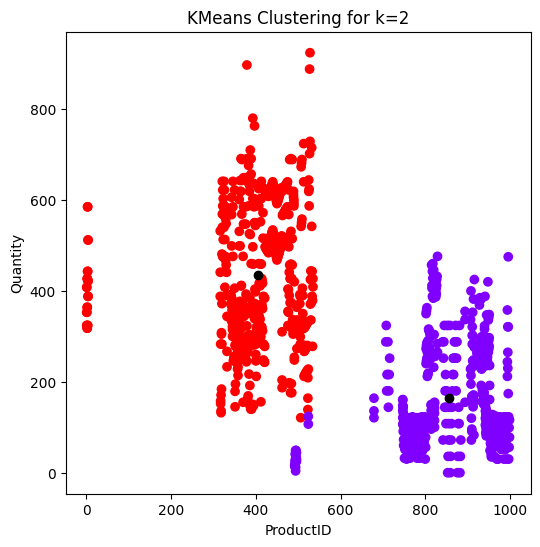


For k=3:
Inter-cluster distance between cluster 0 and cluster 1: 487.3002487178786
Inter-cluster distance between cluster 0 and cluster 2: 209.02205174500696
Inter-cluster distance between cluster 1 and cluster 2: 556.3095967190549
Average intra-cluster distance for cluster 0: 86.62751288153775
Average intra-cluster distance for cluster 1: 156.8326996718238
Average intra-cluster distance for cluster 2: 111.85932044981656


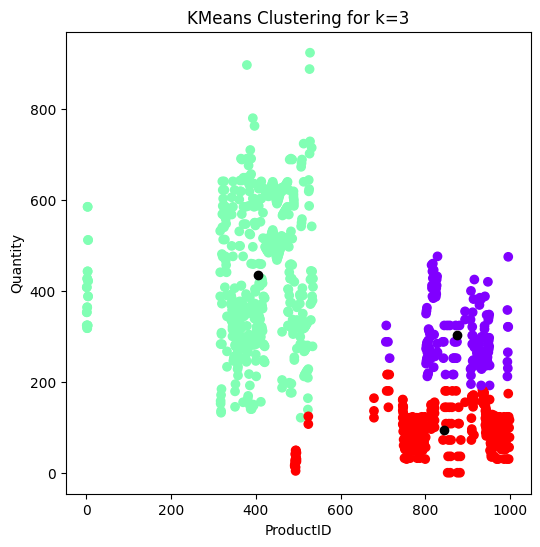


For k=4:
Inter-cluster distance between cluster 0 and cluster 1: 515.5316478321924
Inter-cluster distance between cluster 0 and cluster 2: 204.47785176237514
Inter-cluster distance between cluster 0 and cluster 3: 477.38909346025423
Inter-cluster distance between cluster 1 and cluster 2: 640.4999767737827
Inter-cluster distance between cluster 1 and cluster 3: 270.65445903990974
Inter-cluster distance between cluster 2 and cluster 3: 512.0830722859474
Average intra-cluster distance for cluster 0: 87.76849197533853
Average intra-cluster distance for cluster 1: 89.36763409898047
Average intra-cluster distance for cluster 2: 97.2930047225288
Average intra-cluster distance for cluster 3: 117.62591191187224


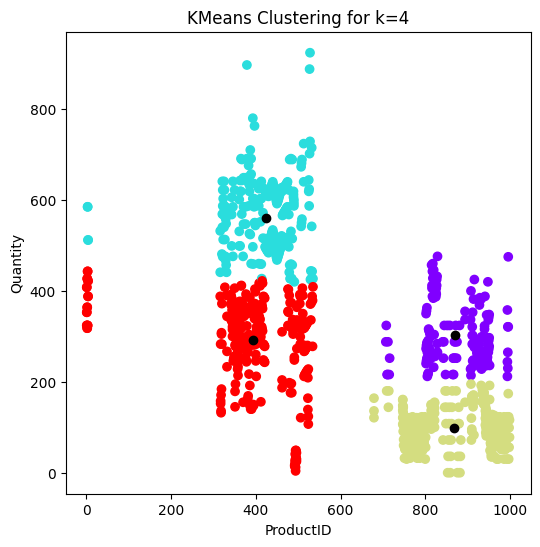


For k=5:
Inter-cluster distance between cluster 0 and cluster 1: 515.7878260750692
Inter-cluster distance between cluster 0 and cluster 2: 252.05884942284746
Inter-cluster distance between cluster 0 and cluster 3: 484.9550178054312
Inter-cluster distance between cluster 0 and cluster 4: 214.10794160318363
Inter-cluster distance between cluster 1 and cluster 2: 570.3756468637083
Inter-cluster distance between cluster 1 and cluster 3: 256.97862338097696
Inter-cluster distance between cluster 1 and cluster 4: 693.7296440542644
Inter-cluster distance between cluster 2 and cluster 3: 417.94800146955123
Inter-cluster distance between cluster 2 and cluster 4: 203.63491857593323
Inter-cluster distance between cluster 3 and cluster 4: 594.8372724137728
Average intra-cluster distance for cluster 0: 85.40387527337288
Average intra-cluster distance for cluster 1: 88.39353860394954
Average intra-cluster distance for cluster 2: 71.98067324144652
Average intra-cluster distance for cluster 3: 108.149

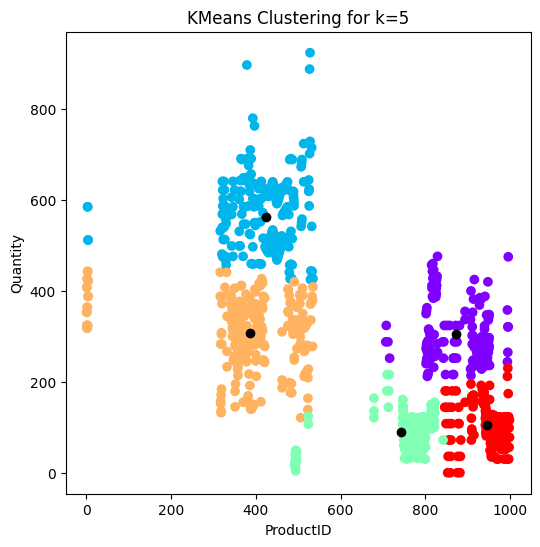


For k=6:
Inter-cluster distance between cluster 0 and cluster 1: 514.4433547912087
Inter-cluster distance between cluster 0 and cluster 2: 251.67177700466544
Inter-cluster distance between cluster 0 and cluster 3: 453.8516307802349
Inter-cluster distance between cluster 0 and cluster 4: 213.71256880133237
Inter-cluster distance between cluster 0 and cluster 5: 874.9029433585765
Inter-cluster distance between cluster 1 and cluster 2: 572.4466370872954
Inter-cluster distance between cluster 1 and cluster 3: 260.5230394098862
Inter-cluster distance between cluster 1 and cluster 4: 693.0641349384001
Inter-cluster distance between cluster 1 and cluster 5: 453.60116018142173
Inter-cluster distance between cluster 2 and cluster 3: 391.78810531964297
Inter-cluster distance between cluster 2 and cluster 4: 202.21312416602245
Inter-cluster distance between cluster 2 and cluster 5: 807.1182781936594
Inter-cluster distance between cluster 3 and cluster 4: 564.6020037964196
Inter-cluster distance 

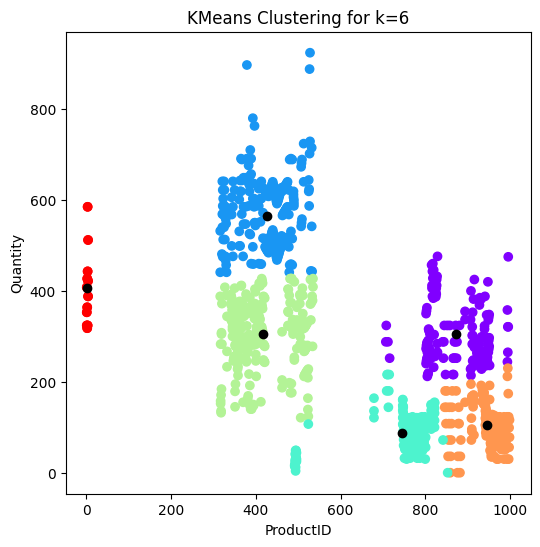


For k=7:
Inter-cluster distance between cluster 0 and cluster 1: 467.95140115905883
Inter-cluster distance between cluster 0 and cluster 2: 228.96517569750247
Inter-cluster distance between cluster 0 and cluster 3: 455.0808629101048
Inter-cluster distance between cluster 0 and cluster 4: 216.83177971219058
Inter-cluster distance between cluster 0 and cluster 5: 874.9029433585765
Inter-cluster distance between cluster 0 and cluster 6: 548.0727518904464
Inter-cluster distance between cluster 1 and cluster 2: 510.8524681064177
Inter-cluster distance between cluster 1 and cluster 3: 203.86313955919206
Inter-cluster distance between cluster 1 and cluster 4: 636.3187825891044
Inter-cluster distance between cluster 1 and cluster 5: 436.48993322582226
Inter-cluster distance between cluster 1 and cluster 6: 150.60011174620746
Inter-cluster distance between cluster 2 and cluster 3: 401.06591478907063
Inter-cluster distance between cluster 2 and cluster 4: 174.50010620094372
Inter-cluster distan

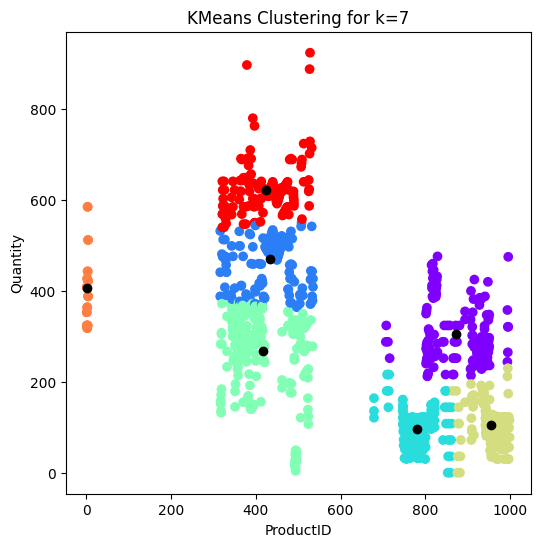


For k=8:
Inter-cluster distance between cluster 0 and cluster 1: 476.54139075528764
Inter-cluster distance between cluster 0 and cluster 2: 228.96517569750253
Inter-cluster distance between cluster 0 and cluster 3: 454.37771026842614
Inter-cluster distance between cluster 0 and cluster 4: 216.83177971219058
Inter-cluster distance between cluster 0 and cluster 5: 461.4830334541025
Inter-cluster distance between cluster 0 and cluster 6: 874.9029433585765
Inter-cluster distance between cluster 0 and cluster 7: 548.5764408227047
Inter-cluster distance between cluster 1 and cluster 2: 526.8588756978114
Inter-cluster distance between cluster 1 and cluster 3: 350.54749959920446
Inter-cluster distance between cluster 1 and cluster 4: 649.1930978960398
Inter-cluster distance between cluster 1 and cluster 5: 171.47077118762553
Inter-cluster distance between cluster 1 and cluster 6: 439.1282538215618
Inter-cluster distance between cluster 1 and cluster 7: 134.16507691662957
Inter-cluster distanc

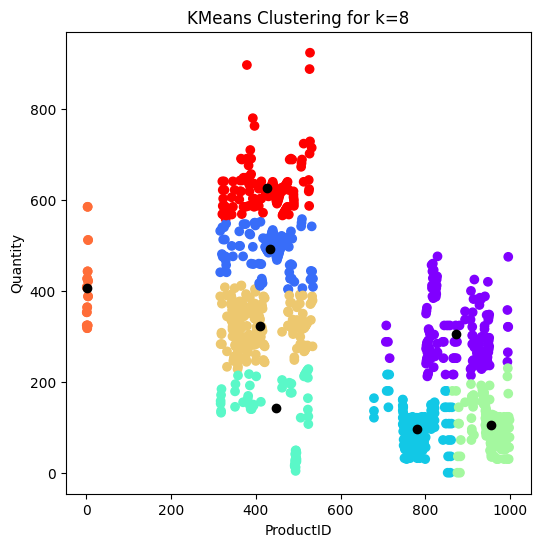

In [50]:
from sklearn.cluster import KMeans
import numpy as np

# Range of k values to try
k_values = range(2, 9)

for k in k_values:
    # Fit the KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_2d)
    
    # Calculate and print inter-cluster distances
    print(f"\nFor k={k}:")
    for i in range(k):
        for j in range(i+1, k):
            diff = kmeans.cluster_centers_[i] - kmeans.cluster_centers_[j]
            dist = np.sqrt(np.sum(diff**2))
            print(f"Inter-cluster distance between cluster {i} and cluster {j}: {dist}")
    
    # Calculate and print intra-cluster distances
    for i in range(k):
        cluster_points = df_2d[kmeans.labels_ == i]
        distances = np.sqrt(np.sum((cluster_points - kmeans.cluster_centers_[i])**2, axis=1))
        avg_distance = np.mean(distances)
        print(f"Average intra-cluster distance for cluster {i}: {avg_distance}")

    # Plot the clusters
    plt.figure(figsize=(6, 6))
    plt.scatter(df_2d['ProductID'], df_2d['Quantity'], c=kmeans.labels_, cmap='rainbow')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black')
    plt.xlabel('ProductID')
    plt.ylabel('Quantity')
    plt.title(f'KMeans Clustering for k={k}')
    plt.show()

# Scatter Map

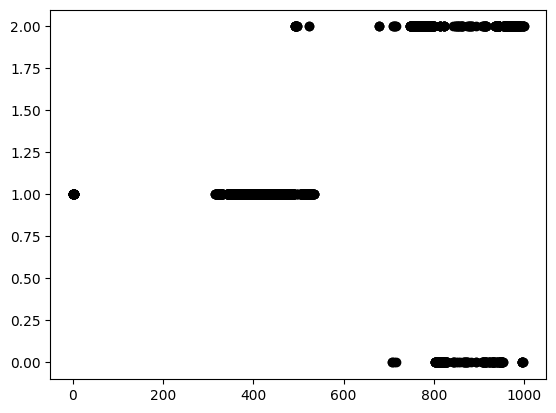

In [54]:
plt.scatter(df_2d['ProductID'], df_2d['Centrum'], color = 'k')
plt.show()

In [56]:
df_2d.groupby('Centrum', as_index=False)['Centrum'].count()

,Centrum
0,161
1,601
2,319


# Cluster Model With 3+ Dimesions

In [57]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
prediction_results = kmeans.fit_predict(df)
prediction_results

array([2, 2, 2, ..., 5, 5, 5])

In [58]:
df['Cluster'] = prediction_results
df.head()

,ProductID,Quantity,AWC Logo Cap,Adjustable Race,All-Purpose Bike Stand,Aniseed Syrup,BB Ball Bearing,Bearing Ball,Bike Wash - Dissolver,Blade,...,"Touring-3000 Yellow, 62","Touring-Panniers, Large",Water Bottle - 30 oz.,"Women's Mountain Shorts, L","Women's Mountain Shorts, M","Women's Mountain Shorts, S","Women's Tights, L","Women's Tights, M","Women's Tights, S",Cluster
0,771.0,49,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
1,771.0,100,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
2,772.0,88,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
3,772.0,65,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
4,773.0,83,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2


In [59]:
df.groupby('Cluster', as_index = False)['Cluster'].count()

,Cluster
0,156
1,294
2,157
3,284
4,166
5,24


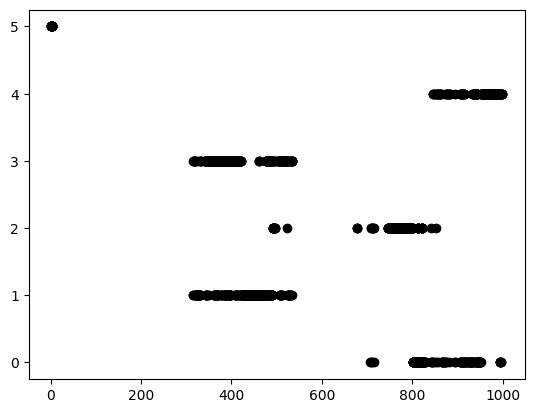

In [60]:
plt.scatter(df['ProductID'], df['Cluster'], color = 'k')
plt.show()